In [1]:
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import time
import pandas as pd
import os.path as osp
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
import cv2
from utils.data_augumentation import (
    Compose,
    Scale,
    RandomRotation,
    RandomMirror,
    Resize,
    Normalize_Tensor,
)
import shutil
from sklearn.model_selection import train_test_split


In [2]:
cuda_num=0

In [3]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [4]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [5]:
def select_file_with_json(rootpath):
    """
    jsonファイルを参照してbutuと背景クラスのみが入っているファイルのみのファイル名をリスト化する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : file_names
        データへのパスを格納したリスト
    """
    json_dir = osp.join(rootpath, "json")
    json_tempate = osp.join(rootpath, "json")
    # print(json_dir)
    # print(osp.exists(json_dir))
    json_files = os.listdir(json_dir)
    filenames = []
    for json_file in json_files:
        path = osp.join(json_tempate, json_file)
        json_open = open(path, "r")
        json_load = json.load(json_open)
        shapes = json_load["shapes"]
        for shape in shapes:
            if shape["label"] != "butu":
                is_butu = False
                break
            is_butu = True
        if is_butu:
            filenames.append(json_file)
    # print(len(filenames))
    return filenames

def make_random_datapath_list(rootpath, filenames):
    """
    学習、検証の画像データとアノテーションデータのファイルパスリストをランダムに作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """
    img_path_list = [
        osp.join(rootpath, "image", "%s.png" % os.path.splitext(filename)[0])
        for filename in filenames
    ]
    anno_path_list = [
        osp.join(
            rootpath, "SegmentationClassPNG", "%s.png" % os.path.splitext(filename)[0]
        )
        for filename in filenames
    ]
    num_train = len(img_path_list) * 8 // 10
    num_val = (len(img_path_list) - num_train) // 2
    num_test = len(img_path_list) - num_train - num_val
    (tmp_img, test_img_list, tmp_anno, test_anno_list) = train_test_split(
        img_path_list,
        anno_path_list,
        train_size=num_train + num_val,
        test_size=num_test,
        shuffle=True,
        random_state=1,
    )

    (train_img_list, val_img_list, train_anno_list, val_anno_list) = train_test_split(
        tmp_img,
        tmp_anno,
        train_size=num_train,
        test_size=num_val,
        shuffle=True,
        random_state=1,
    )
    return (
        train_img_list,
        train_anno_list,
        val_img_list,
        val_anno_list,
        test_img_list,
        test_anno_list,
    )


class DataTransform:
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            "train": Compose(
                [
                    Scale(scale=[0.5, 1.5]),
                    RandomRotation(angle=[-10, 10]),
                    RandomMirror(),
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std),
                ]
            ),
            "val": Compose(
                [
                    Resize(input_size),
                    Normalize_Tensor(color_mean, color_std),
                ]
            ),
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'val'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        """画像の枚数を返す"""
        return len(self.img_list)

    def __getitem__(self, index):
        """
        前処理をした画像のTensor形式のデータとアノテーションを取得
        """
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        """画像のTensor形式のデータ、アノテーションを取得する"""

        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)  # [高さ][幅]
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)  # [高さ][幅]
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

In [6]:
def make_dataloder(rootpath, batch_size=8):
    filenames = select_file_with_json(rootpath)
    (
        train_img_list,
        train_anno_list,
        val_img_list,
        val_anno_list,
        _,
        _,
    ) = make_random_datapath_list(rootpath, filenames)

    color_mean = 0.18228737997050898
    color_std = 0.15940997135888293

    train_dataset = VOCDataset(
        train_img_list,
        train_anno_list,
        phase="train",
        transform=DataTransform(
            input_size=475, color_mean=color_mean, color_std=color_std
        ),
    )

    val_dataset = VOCDataset(
        val_img_list,
        val_anno_list,
        phase="val",
        transform=DataTransform(
            input_size=475, color_mean=color_mean, color_std=color_std
        ),
    )

    train_dataloader = data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
    return dataloaders_dict


def lambda_epoch(epoch):
    max_epoch = 1
    return math.pow((1 - epoch / max_epoch), 0.9)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [7]:
def train_model(
    net,
    dataloaders_dict,
    scheduler,
    optimizer,
    num_epochs,
    cross_entropy_loss,
    cuda_num=0,
    batch_multiplier=3,
):
    device = torch.device(
        "cuda:" + str(cuda_num) if torch.cuda.is_available() else "cpu"
    )
    print("使用デバイス：", device)
    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size
    # print(batch_size)

    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print("-------------")
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-------------")

        # epochごとの訓練と検証のループ
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print("（train）")

            else:
                if (epoch + 1) % 5 == 0:
                    net.eval()  # モデルを検証モードに
                    print("-------------")
                    print("（val）")
                else:
                    # 検証は5回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # print(imges.shape)
                # print(anno_class_imges.shape)
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                # multiple minibatchでのパラメータの更新
                if (phase == "train") and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(imges)
                    # print(outputs.shape)
                    loss = (
                        cross_entropy_loss(
                            outputs,
                            anno_class_imges.long(),
                        )
                        / batch_multiplier
                    )
                    # 訓練時はバックプロパゲーション
                    if phase == "train":
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        if iteration % 10 == 0:  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(
                                "イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.".format(
                                    iteration,
                                    loss.item() / batch_size * batch_multiplier,
                                    duration,
                                )
                            )
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print("-------------")
        print(
            "epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}".format(
                epoch + 1,
                epoch_train_loss / num_train_imgs,
                epoch_val_loss / num_val_imgs,
            )
        )
        print("timer:  {:.4f} sec.".format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {
            "epoch": epoch + 1,
            "train_loss": epoch_train_loss / num_train_imgs,
            "val_loss": epoch_val_loss / num_val_imgs,
        }
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(
        net.state_dict(),
        "/localtmp/users/rin/Unet_" + str(epoch + 1) + ".pth",
    )
    shutil.move(
        "/localtmp/users/rin/Unet_" + str(epoch + 1) + ".pth",
        "./weights",
    )

In [8]:
rootpath = "../data/x3"
dataloaders_dict=make_dataloder(rootpath=rootpath, batch_size=6)

In [9]:
net = UNet(n_channels=1, n_classes=2)
print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [10]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [11]:
optimizer = optim.SGD(net.parameters(), lr=1e-2,momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [12]:
device = torch.device(
    "cuda:" + str(cuda_num) if torch.cuda.is_available() else "cpu"
)
print("使用デバイス：", device)
weights = torch.tensor([1.0, 100.0]).to(device)
net.apply(weights_init)
# train_model(
#     net,
#     dataloaders_dict,
#     scheduler,
#     optimizer,
#     num_epochs=1,
#     cross_entropy_loss=nn.CrossEntropyLoss(weight=weights),
#     cuda_num=cuda_num,
#     batch_multiplier=4,
# )

使用デバイス： cuda:0
使用デバイス： cuda:0
-------------
Epoch 1/1
-------------
（train）


/home/usrs/rin/miniconda3/envs/cuda_10.1/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


イテレーション 10 || Loss: 0.1686 || 10iter: 16.3255 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:0.1735 ||Epoch_VAL_Loss:0.0000
timer:  23.2537 sec.


！ここから推論コード！

In [18]:
net = UNet(n_channels=1, n_classes=2)
state_dict = torch.load("./weights/Unet_v4300.pth",map_location={'cuda:'+str(cuda_num): 'cpu'})
print("使用デバイス: cuda:"+str(cuda_num))
net.load_state_dict(state_dict)
print('ネットワーク設定完了：学習済みの重みをロードしました')

使用デバイス: cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


In [19]:
filenames = select_file_with_json(rootpath)
(
    _,
    _,
    _,
    _,
    test_img_list,
    test_anno_list,
) = make_random_datapath_list(rootpath, filenames)
color_mean = 0.18228737997050898
color_std = 0.15940997135888293
test_dataset = VOCDataset(test_img_list, test_anno_list, phase="val", transform=DataTransform(
input_size=475, color_mean=color_mean, color_std=color_std))

In [20]:
def show_detection(test_img_list,test_anno_list,test_dataset):
    """
    推論結果を表示する関数（緑:tp,赤:fp,青:fn）
    
    input:
        test_img_list
        test_anno_list
        test_dataset
    """
    time_all=0
    for index in range(len(test_img_list)):
        image_file_path = test_img_list[index]
        img_original = Image.open(image_file_path).convert(mode="RGB")   # [高さ][幅][色RGB]
        img_width, img_height = img_original.size
        anno_file_path = test_anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
        gt =Image.open(anno_file_path).convert('RGBA')
        p_palette = anno_class_img.getpalette()
        net.eval()
        img, anno_class_img = test_dataset.__getitem__(index)
        x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
        start = time.time()
        outputs = net(x)
        t = time.time() - start
        time_all+=t
        y = outputs
        y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
        y = np.argmax(y, axis=0)
        anno_class_img = Image.fromarray(np.uint8(y), mode="P")
        anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
        anno_class_img.putpalette(p_palette)
        anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換
        trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
        for x in range(img_width):
            for y in range(img_height):
                pixel = anno_class_img.getpixel((x, y))
                pixel_gt = gt.getpixel((x, y))
                if (pixel[0] != 0 or pixel[1] != 0 or pixel[2] != 0)and(pixel_gt[0] != 0 or pixel_gt[1] != 0 or pixel_gt[2] != 0):
                    trans_img.putpixel((x, y), (0, 255,0, 200))
                elif pixel[0] != 0 or pixel[1] != 0 or pixel[2] != 0 :
                    trans_img.putpixel((x, y), (120, 0,0, 200))
                elif pixel_gt[0] != 0 or pixel_gt[1] != 0 or pixel_gt[2] != 0:
                    trans_img.putpixel((x, y), (0, 0, 255, 200))
        result = Image.alpha_composite(img_original.convert('RGBA'), trans_img)
        plt.imshow(result)
        plt.show()
    print(time_all)

緑：正しい推論、赤:間違った推論、青:推論されなかった gt

In [25]:
# show_detection(test_img_list,test_anno_list,test_dataset)

In [26]:
def generate_true_pred(net,test_anno_list,test_dataset):
    """
    y_trueとy_predを出力する関数

    input: 
        anno_img:PIL.Image.Image image mode=RGB の推論データ情報のリスト
        anno_img_gt:PIL.Image.Image image mode=RGB のgtデータ情報のリスト
    return:
        y_true_list
        y_pred_list
    """
    y_true_list=[]
    y_pred_list=[]
    softmax=nn.Softmax(dim=1)
    for index,gt_path in enumerate(test_anno_list):
        gt = Image.open(gt_path)   # [高さ][幅]
        # p_palette = gt.getpalette()
        img_width, img_height = gt.size
        y_true=np.array(gt).flatten()
        y_true_list=np.hstack((y_true_list, y_true))
        img_475, _ = test_dataset.__getitem__(index)
        net.eval()
        x = img_475.unsqueeze(0)
        outputs = net(x)
        y = softmax(outputs)
        y = y[0].detach().numpy()
        y=y[1]
        detection = Image.fromarray(np.float32(y))
        detection = detection.resize((img_width, img_height), Image.NEAREST)
        # detection.putpalette(p_palette)
        y_pred=np.array(detection).flatten()
        y_pred_list=np.hstack((y_pred_list,y_pred))

    return y_true_list,y_pred_list

In [27]:
y_true_list,y_pred_list=generate_true_pred(net,test_anno_list,test_dataset)

[0.0068322  0.00682941 0.00682946 ... 1.         1.         1.        ]
[1.00000000e+00 9.99584437e-01 9.99584437e-01 ... 1.45446990e-03
 4.15562828e-04 0.00000000e+00]
[0.00255525 0.00255525 0.00255529 ... 0.99998832 0.99998891 0.99999177]


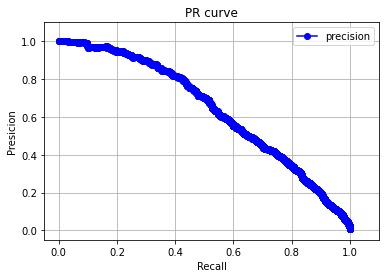

auc: 0.6403756480680405


In [28]:
from sklearn.metrics import precision_recall_curve,auc
precision, recall, thresholds = precision_recall_curve(y_true_list, y_pred_list)
print(precision)
print(recall)
print(thresholds)
fig, ax = plt.subplots()
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.grid()
ax.set_title("PR curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Presicion")
ax.plot(recall, precision, "bo-", label="precision")
ax.legend()
plt.show()

# my_auc=(-1)*(np.diff(recall) * precision[1:]).sum()
# print("auc: "+str(my_auc))
print("auc: "+str(auc(recall,precision)))

/home/usrs/rin/miniconda3/envs/cuda_10.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  if sys.path[0] == '':


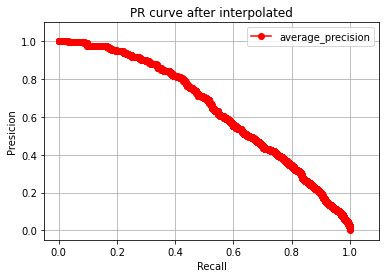

average_precision: 0.6409863371552706


In [29]:
modified_recall = np.concatenate([[1], recall, [0]])
modified_precision = np.concatenate([[0], precision, [0]])
modified_precision2 = np.maximum.accumulate(modified_precision)
average_precision = (-1)*(np.diff(modified_recall) * modified_precision2[1:]).sum()
fig, ax = plt.subplots()
ax.set_xlim(-0.05, 1.1)
ax.set_ylim(-0.05, 1.1)
ax.grid()
ax.set_title("PR curve after interpolated")
ax.set_xlabel("Recall")
ax.set_ylabel("Presicion")
ax.plot(modified_recall, modified_precision2, "bo-", label="average_precision",color='red')
ax.legend()
plt.show()
print("average_precision: "+str(auc(modified_recall, modified_precision2)))